# Querying MPC for objects in Allen Fields

## First load the pointing group info

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp

import healpy as hp
import pointing_groups as pg
import requests

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io.votable import parse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import NoConvergence

from queryMPC import runMPCRequests
from queryMPC import matchSingleVisit
from plottingTools import makeStamps

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [2]:
with open('PickledPointings.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)
    
den_visit,den_ccd,den_stellarnum = np.loadtxt('ref_data.txt',unpack=True)
unique_den_visit = np.unique(den_visit)
max_stellarnum = []
_= [ max_stellarnum.append(np.max(den_stellarnum[den_visit==visit])) for visit in unique_den_visit ]
max_stellarnum = np.array(max_stellarnum)

for i,group in enumerate(Pointing_Groups):
    group_max = np.concatenate([ (max_stellarnum[(unique_den_visit==x)]) for x in np.array(Pointing_Groups[i]["visit_id"],dtype=np.float_) ])
    if not(group_max.size):
        group_max=[-9999.]
    group_max = np.max(group_max)
    Pointing_Groups[i]['stellar_density'] = group_max
    
# visitToIndex is a dictionary that returns the index of a given visit
visitToIndex = {}
for i,pointing in enumerate(Pointing_Groups):
    for visit in pointing['visit_id']:
        visitToIndex[str(visit)] = i

## Set up tools for MPC querying

## Pick a pointing group and get data with `runMPCRequests`

This will query the online MPC database and get a dataframe with all MPC objects within 90 arcminutes of the center of each pointing.

In [3]:
# Get all MPC objects within 90 arcminutes of the pointing group center
pgNum=300 # Pointing Group Number as assigned in NEO_Fields
resultsDF = runMPCRequests(Pointing_Groups[pgNum], str(pgNum))
# Initialize ccd, x_pixel, and y_pixel values
# This prepares the dataframe for the pixel matching
resultsDF['ccd'] = -99
resultsDF['x_pixel'] = -99
resultsDF['y_pixel'] = -99
# Calculate total motion
resultsDF['total_motion'] = np.sqrt(resultsDF['ra_motion']**2. + resultsDF['dec_motion']**2.)

     0433932   2015 04 18.27432 13 22 27.430-08 21 51.00                     W84
     0433936   2015 04 18.27756 13 22 27.460-08 21 49.60                     W84
     0433940   2015 04 18.28078 13 22 27.500-08 21 52.30                     W84
     0433945   2015 04 18.28872 13 22 27.620-08 21 51.80                     W84
     0433949   2015 04 18.29191 13 22 27.610-08 21 51.60                     W84
     0434610   2015 04 19.26575 13 22 27.680-08 21 50.10                     W84
     0434614   2015 04 19.26900 13 22 27.750-08 21 49.90                     W84
     0434618   2015 04 19.27225 13 22 27.670-08 21 54.60                     W84
     0434622   2015 04 19.27547 13 22 27.920-08 21 51.60                     W84
     0434626   2015 04 19.27871 13 22 27.690-08 21 52.20                     W84
     0435498   2015 04 21.26670 13 22 27.340-08 22 00.00                     W84
     0435502   2015 04 21.27007 13 22 27.200-08 22 04.50                     W84
     0435506   2015 04 21.27

In [4]:
# Match the objects from MPC with pixel locations in the DECam NEO Survey
# Can comment this out if you don't want to select on slow movers (total_motion is arcsec/hr.)
# Cut the dataframe based on desired brightness and speed
cutDF = resultsDF.query('v_mag > 21 and total_motion < 20')
cutDF = cutDF.reset_index(drop=True)
# Generate a list of visits in the pointing group
nightVisits = np.unique(cutDF['visit_id'])
# Generate the path to the data
dataPath = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/Pointing_Group_300/warps/%i' % pgNum

def matchPixels(visit):
    """This is a wrapper for matchSingleVisit.
    It allows it to easily run in parallel with a simple
    pool.map() call.
    """
    visitDF = cutDF.query('visit_id == %i' % visit)
    visitDF = visitDF.reset_index(drop=True)
    visitDF = matchSingleVisit(visitDF,visit,dataPath)
    print('Processed visit {}'.format(visit))
    return(visitDF)

with mp.Pool(20) as pool:
    results = pool.map(matchPixels,nightVisits)
# Concatenate the results back into a single dataframe.
objectDF = pd.concat(results)

Processed visit 435506
Processed visit 433945
Processed visit 435502
Processed visit 435514
Processed visit 435498
Processed visit 436174
Processed visit 433949
Processed visit 434614
Processed visit 433936
Processed visit 434618
Processed visit 434610
Processed visit 436190
Processed visit 436178
Processed visit 433932
Processed visit 436182
Processed visit 433940
Processed visit 435510
Processed visit 434622
Processed visit 434626
Processed visit 436186


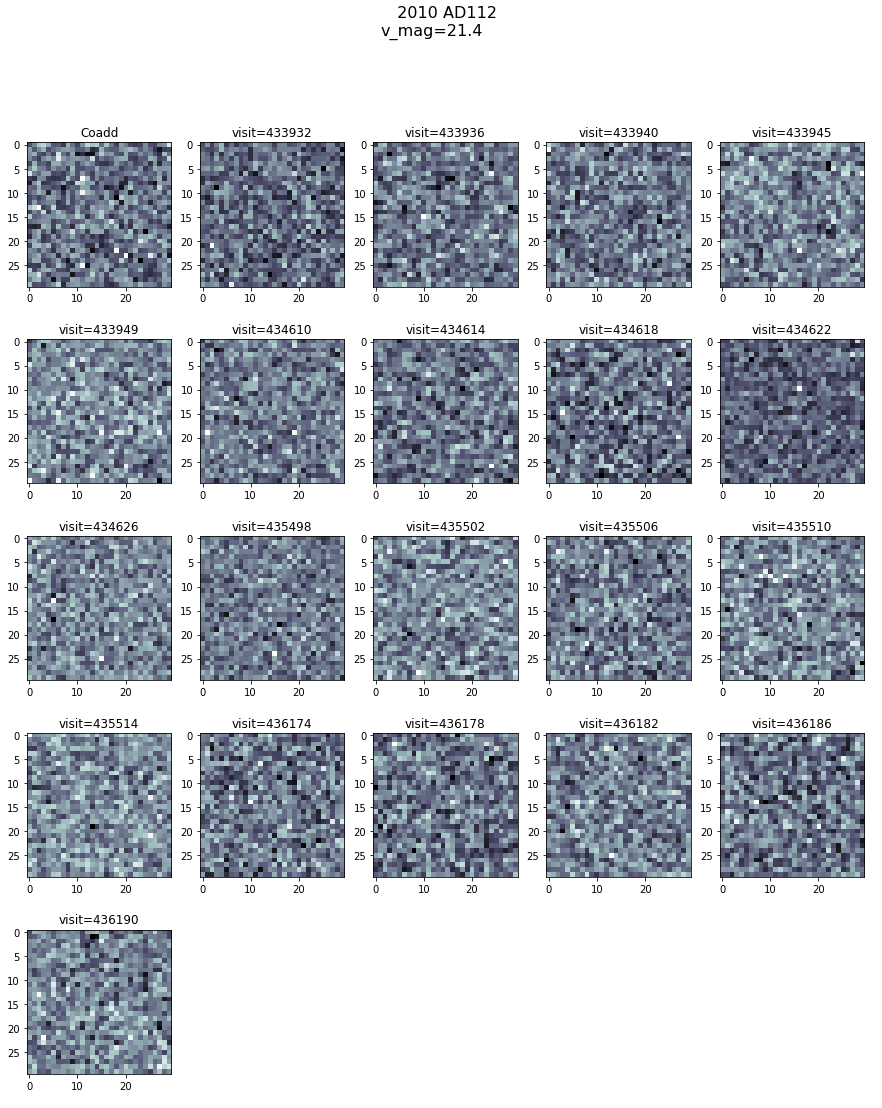

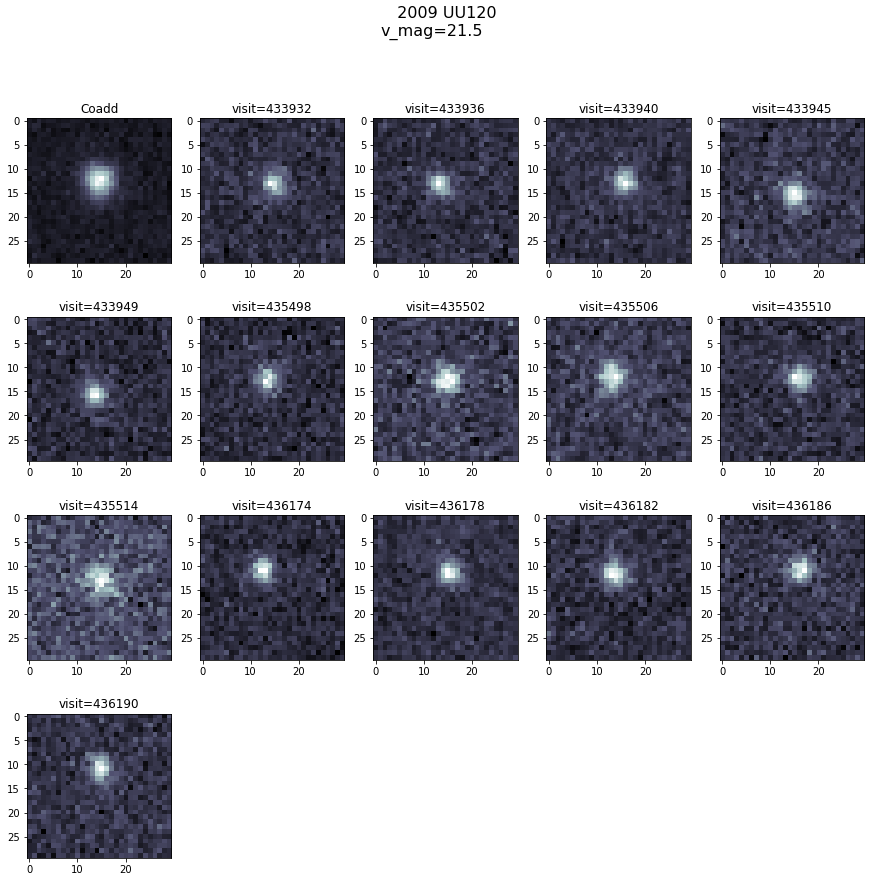

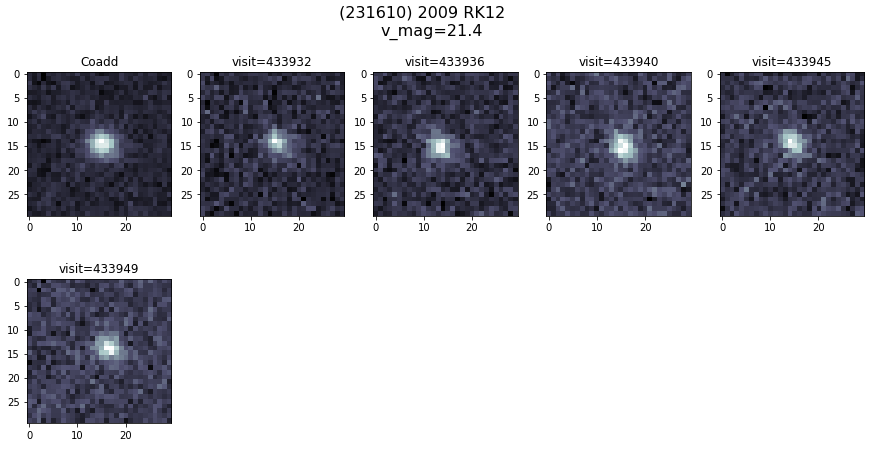

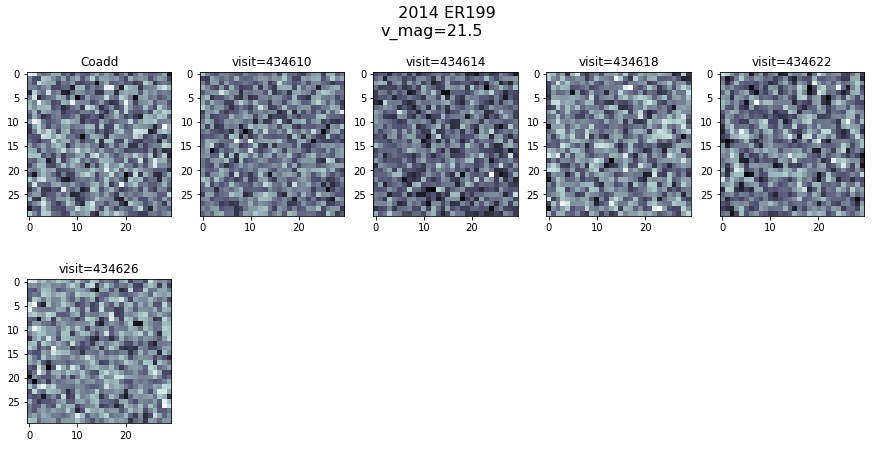

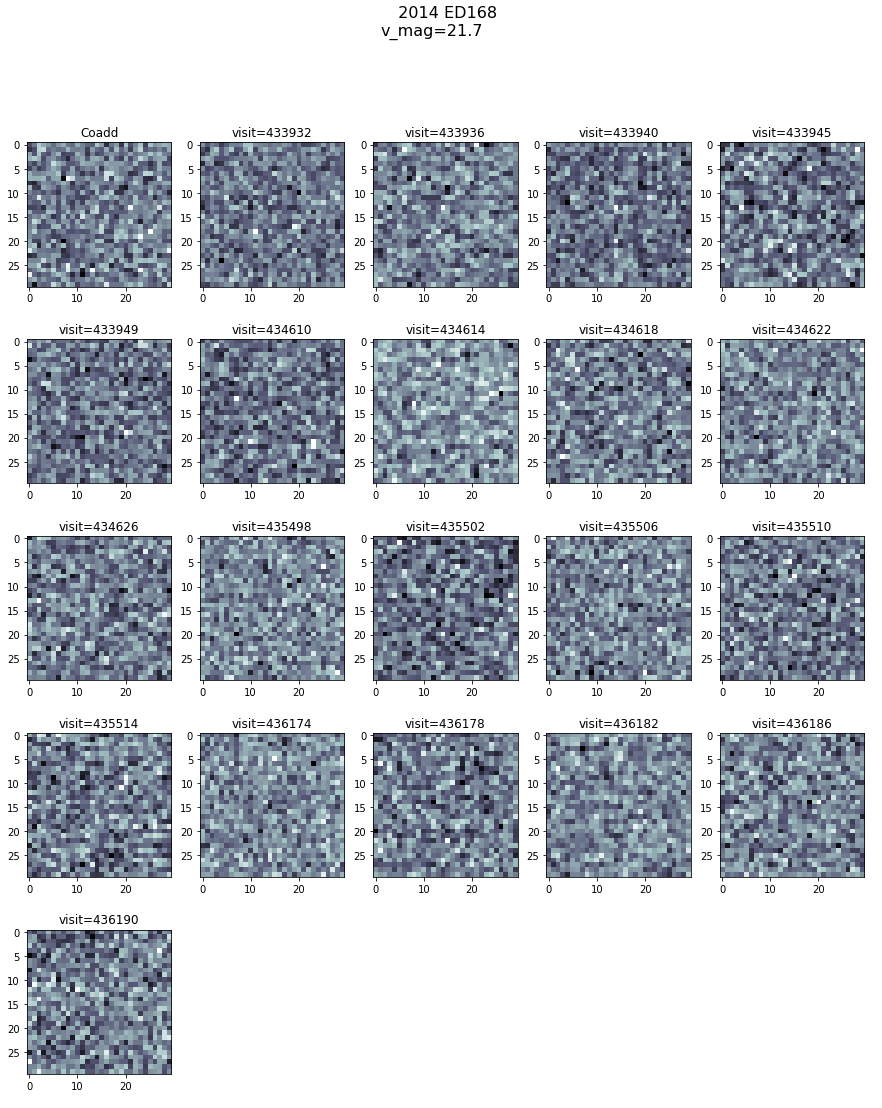

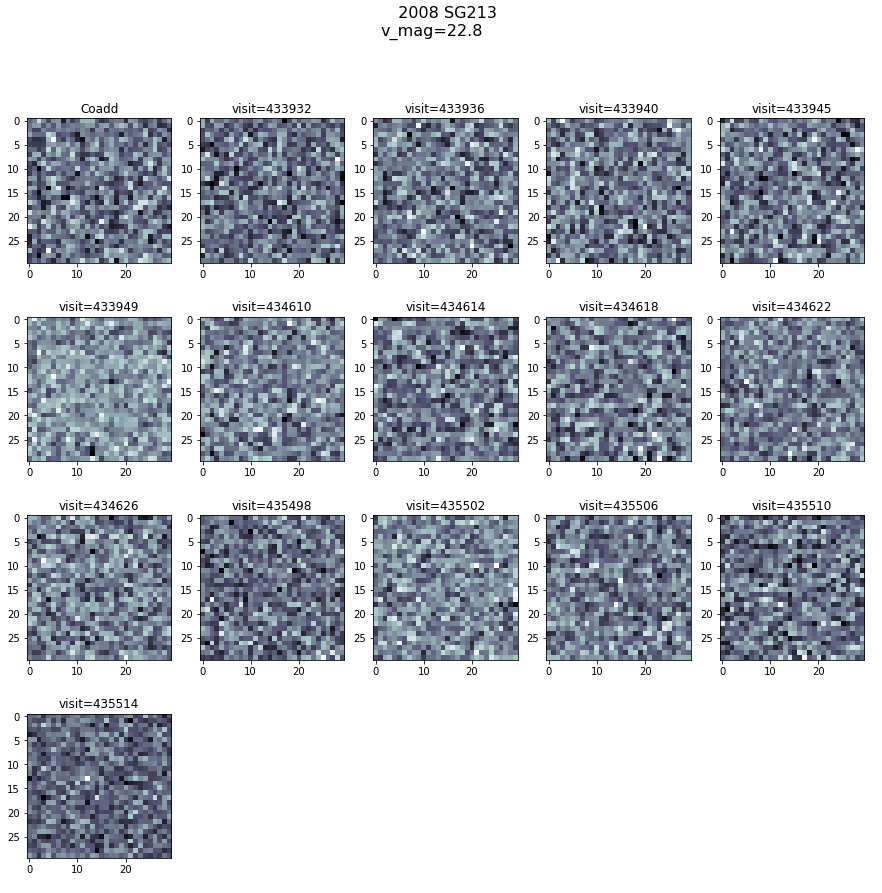

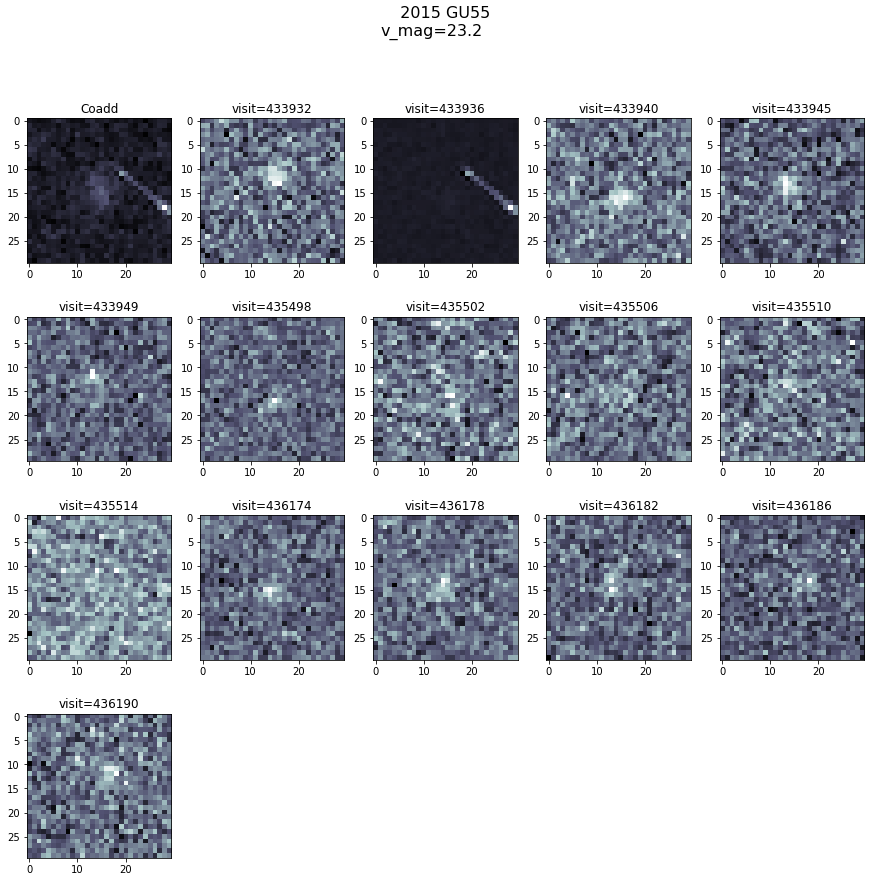

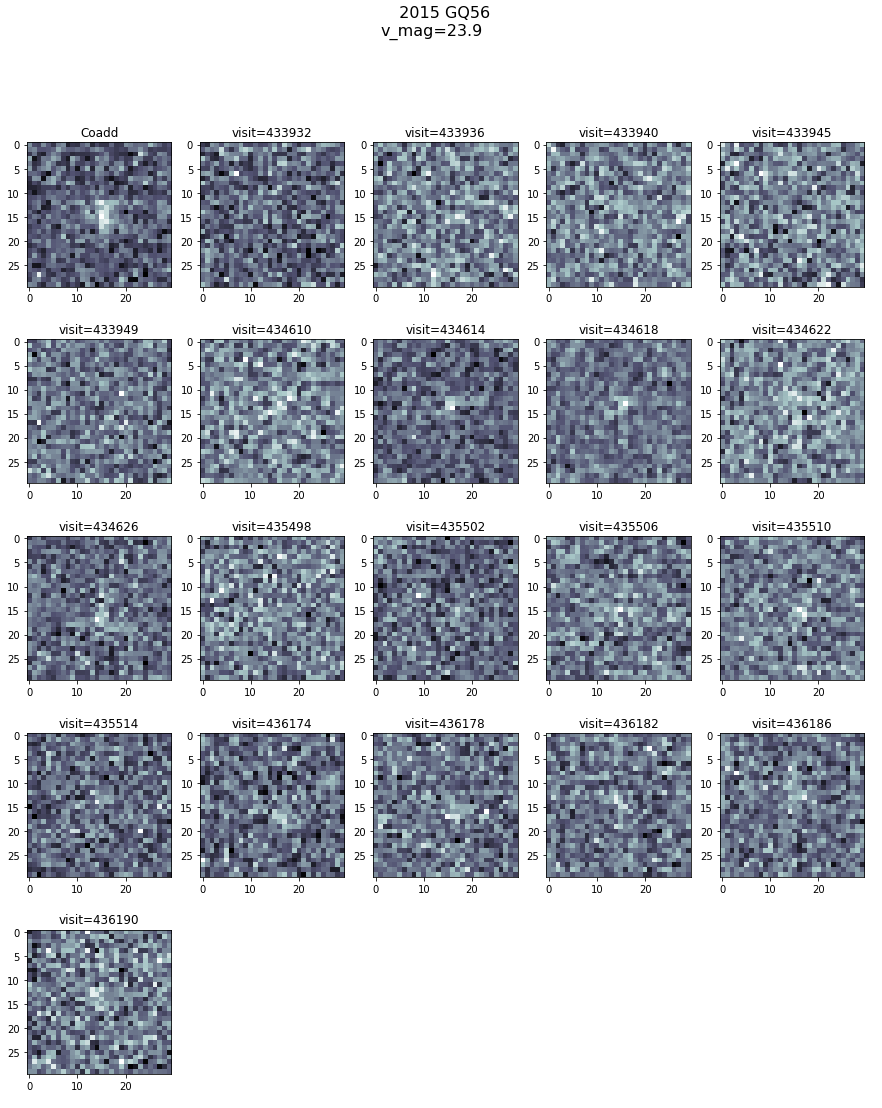

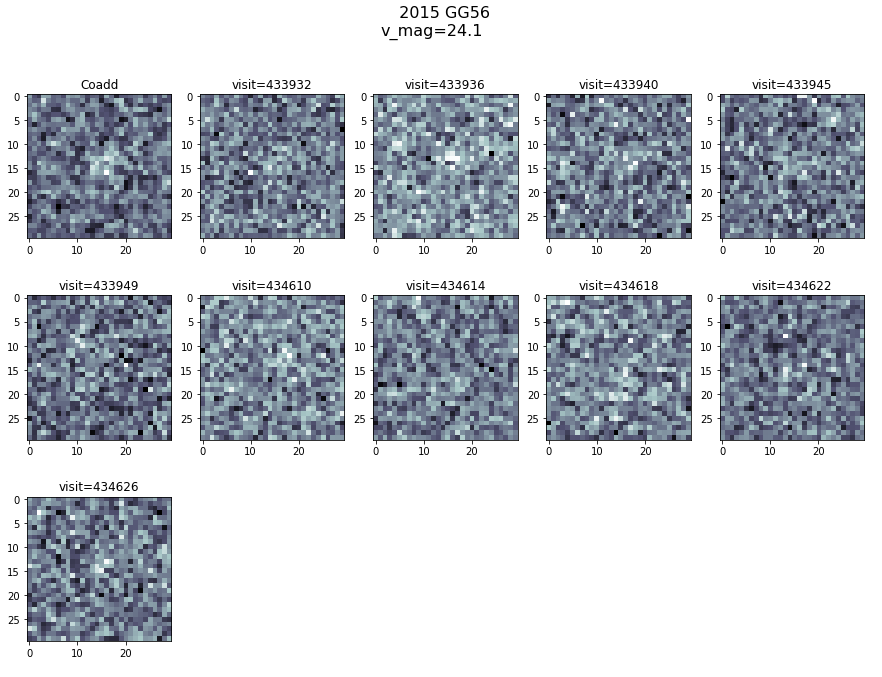

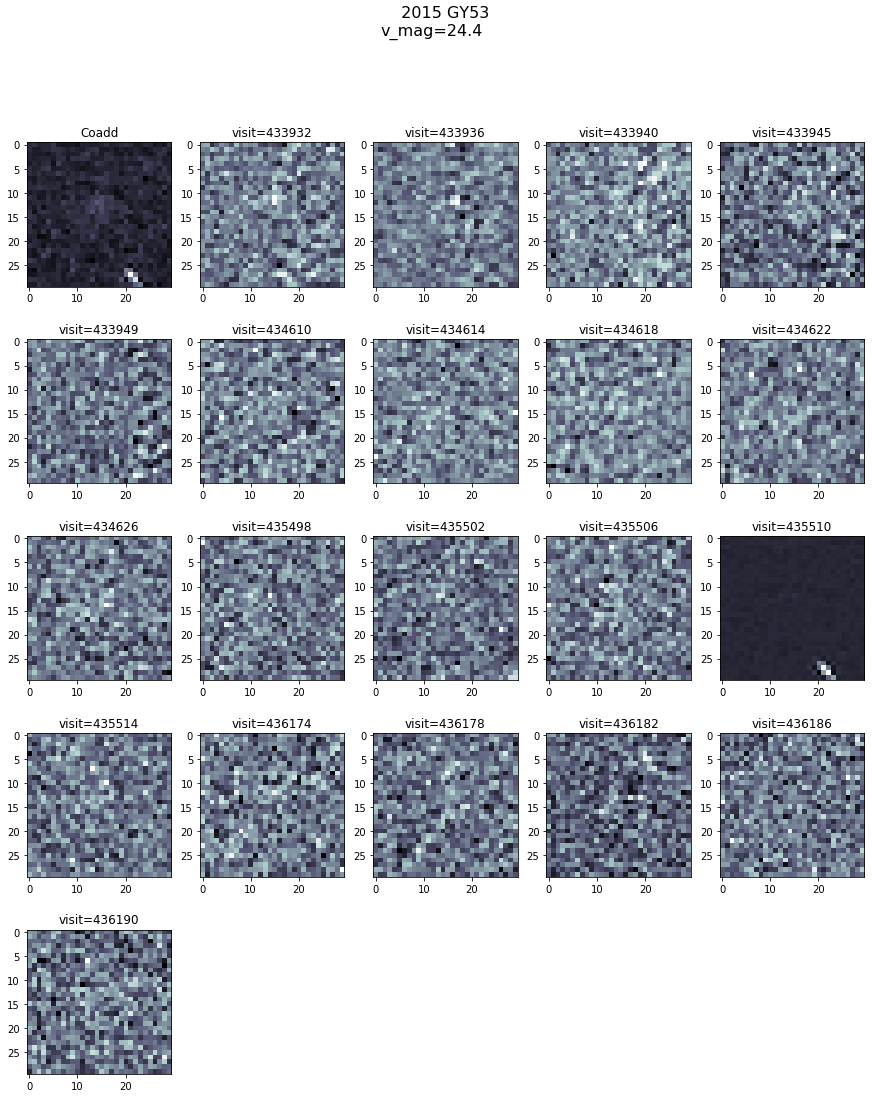

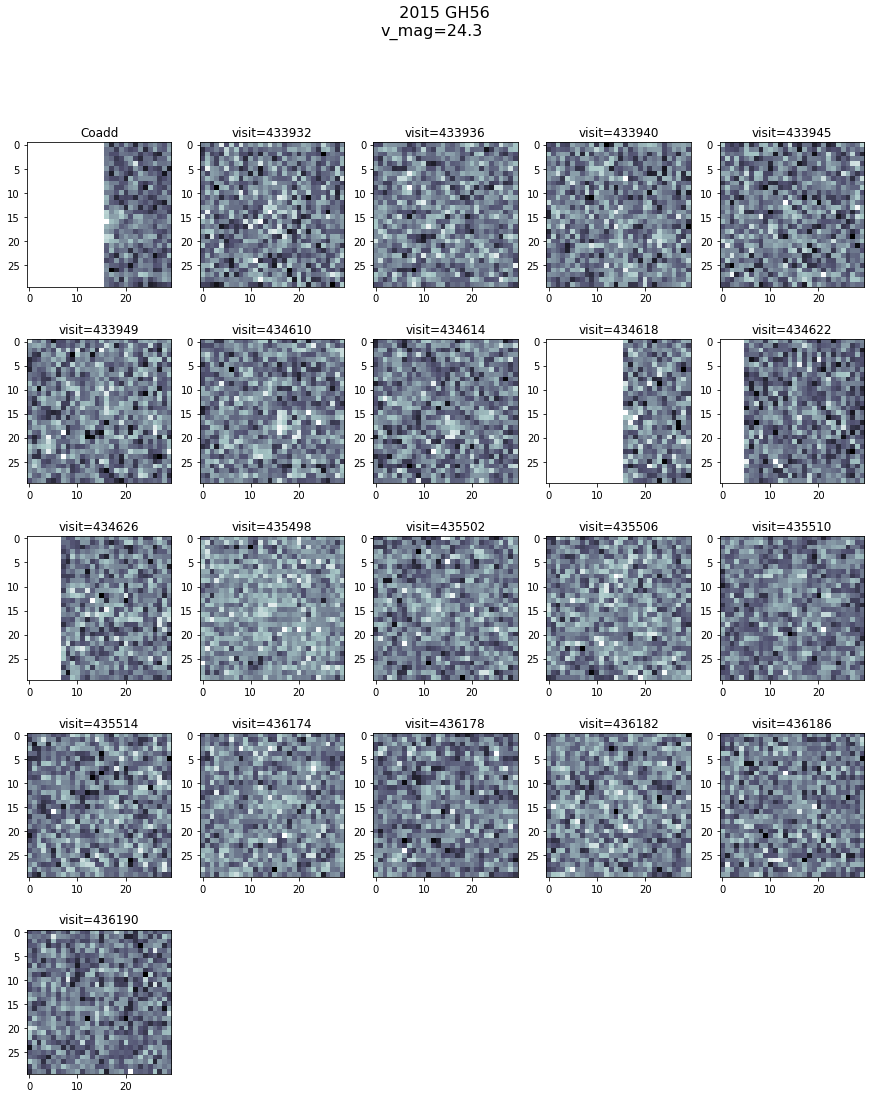

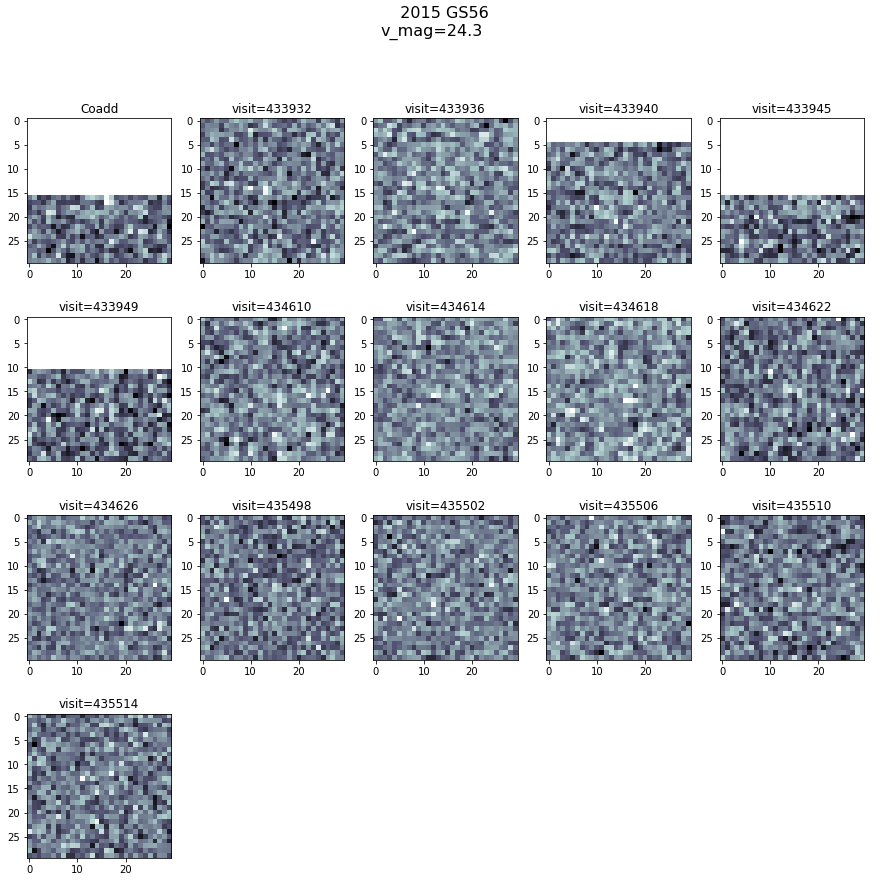

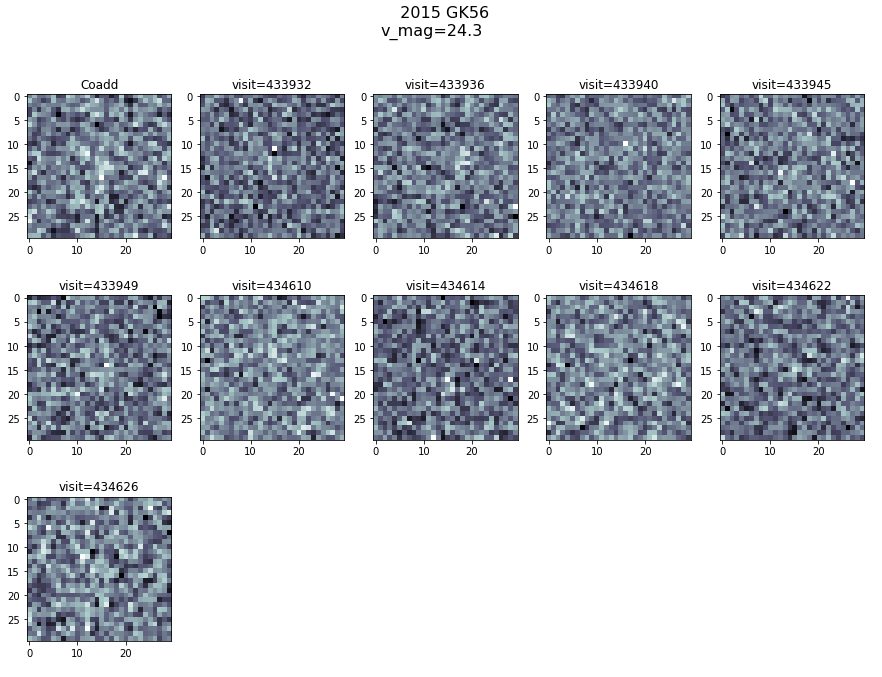

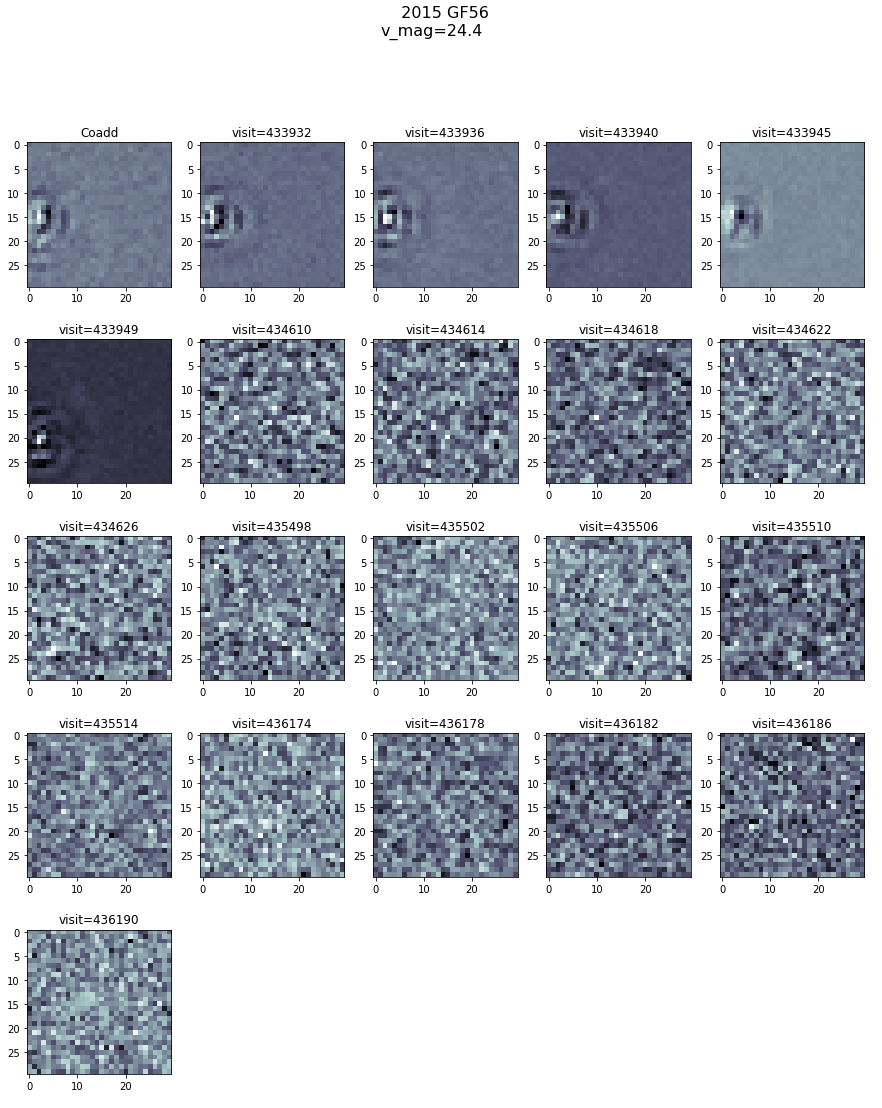

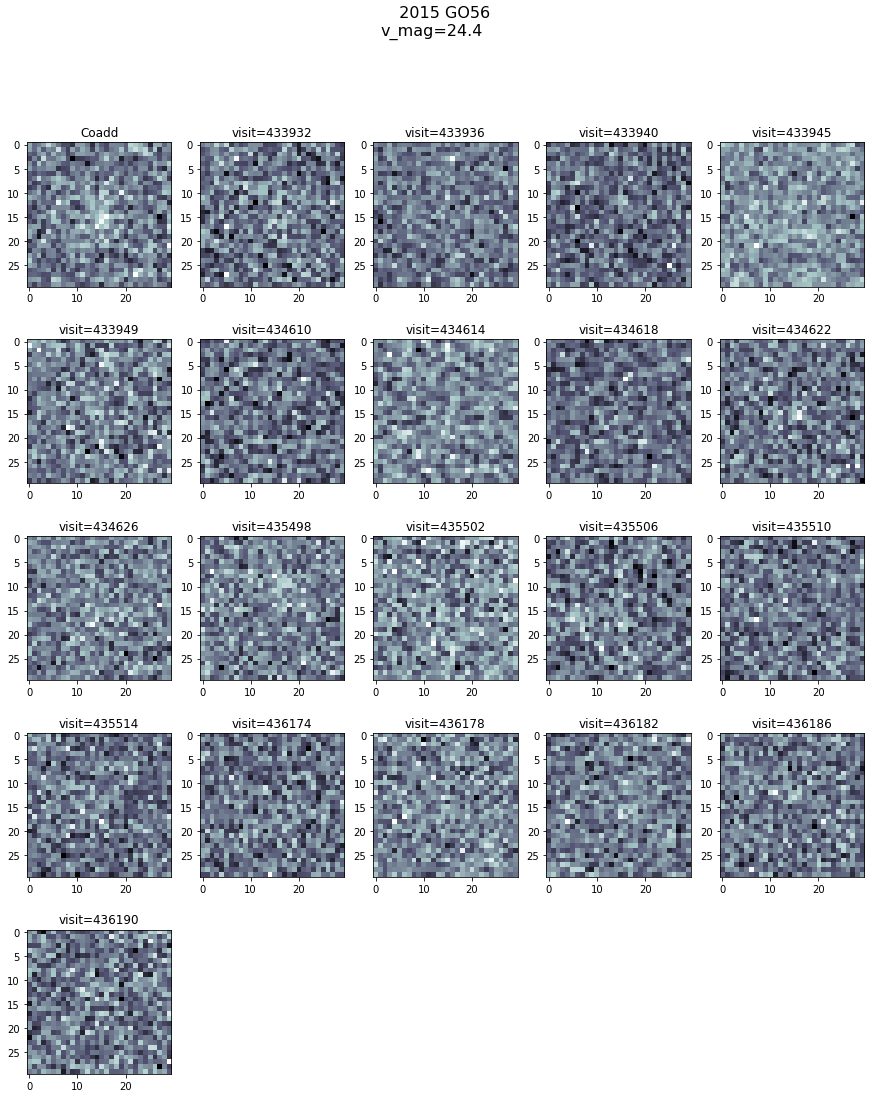

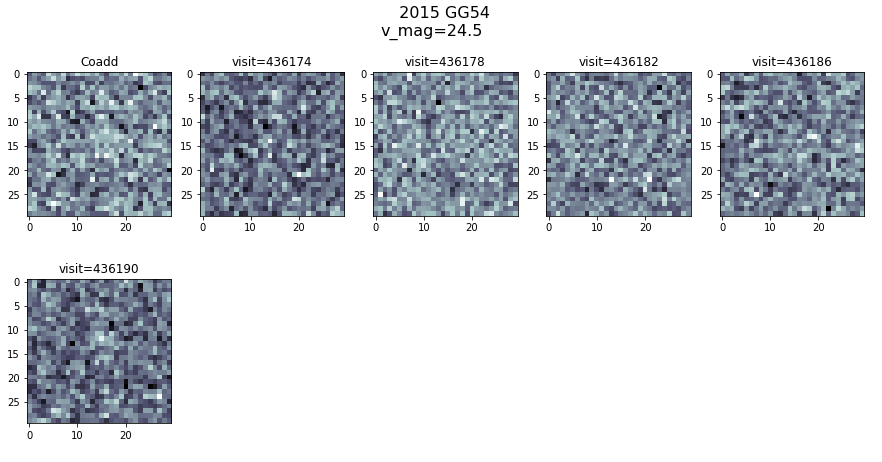

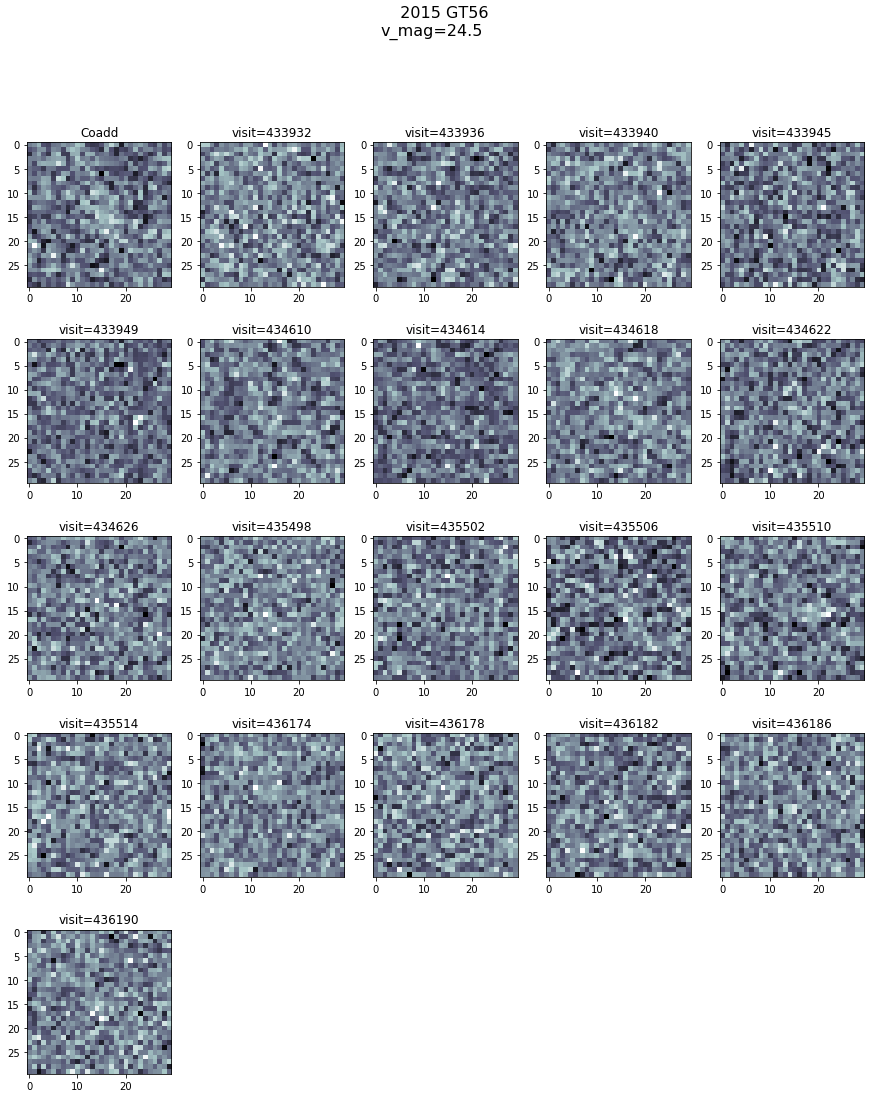

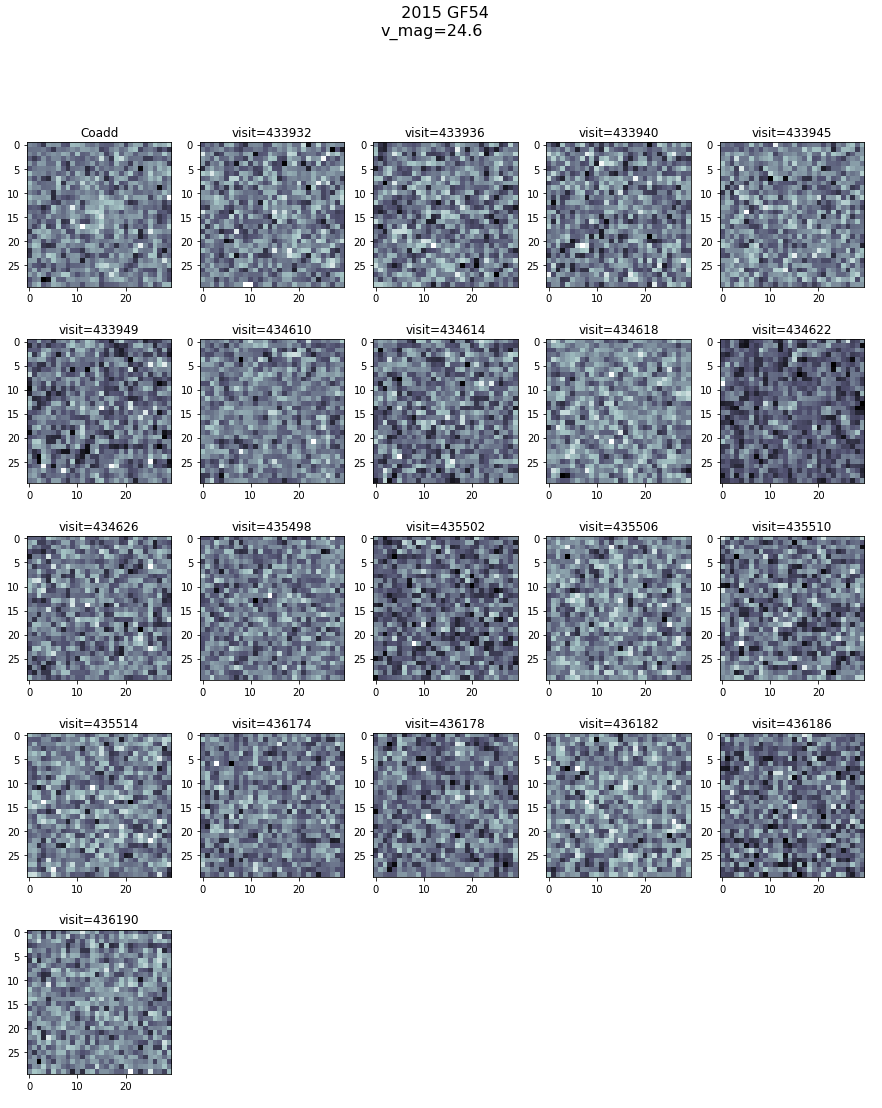

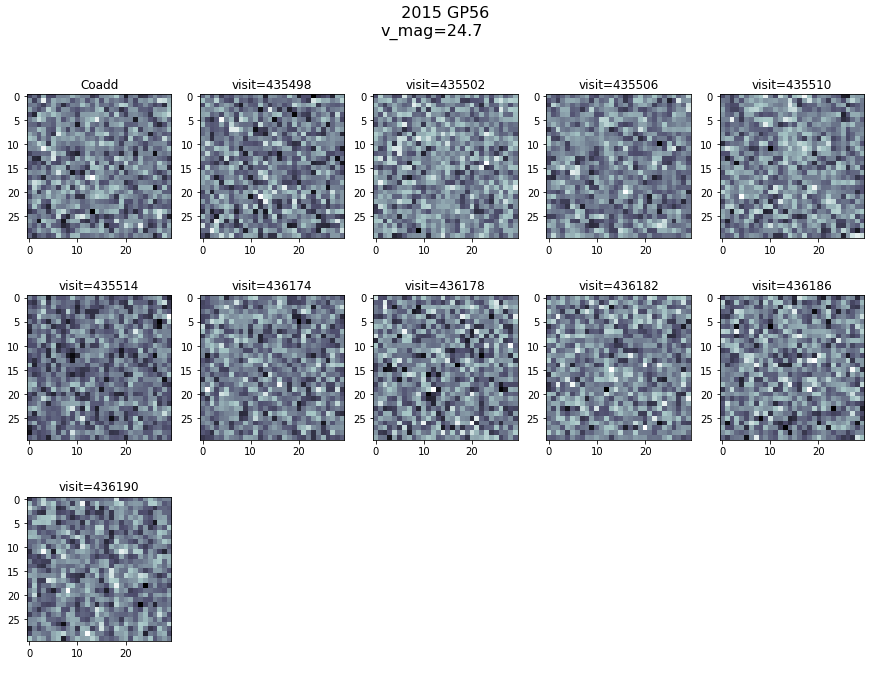

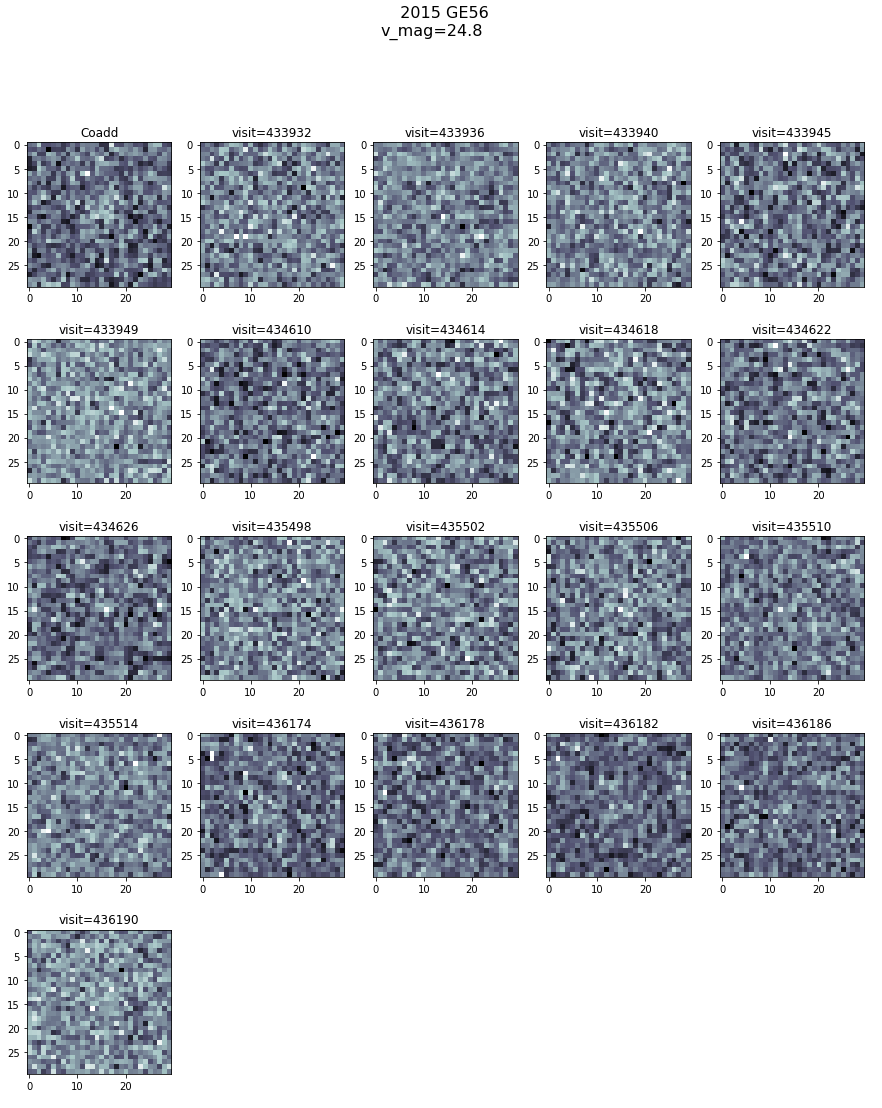

In [6]:
objectDF = objectDF.query('ccd>-1')

filepath = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/Pointing_Group_300/warps/{:03}'
# Pointing group number. See PickledPointings.pkl for more info
pgNum=300

# Generate a list of names and sort by magnitude
cutOL = objectDF.drop_duplicates('name')
cutOL = cutOL.sort_values('v_mag')
## Make cuts to the object_list dataframe in order to select the object of interest
#cutOL = objectList[(objectList['ccd']==ccd) & (objectList['visit_id']==visit_id) & (objectList['v_mag']<22)]
for name in cutOL['name'].get_values():
    makeStamps(name,objectDF,filepath.format(pgNum))

In [8]:
# Write the moving objects to a text file for further analysis
datafile = 'objects300_multi.txt'

init_data = True
for i in range(62):
    full_query = objectDF.query('ccd == '+str(i))
    query = full_query.drop(columns=['ra_hour','ra_min','ra_sec','dec_deg','dec_min','dec_sec','ra_motion','dec_motion'])
    if len(query) > 5:
        if init_data:
            query.to_csv(datafile,sep=',',index=False)
            init_data=False
            with open(datafile,'a') as f:
                f.write('\n')
        else:
            query.to_csv(f,sep=',',header=False,mode='a',index=False)
            with open(datafile,'a') as f:
                f.write('\n')